*** The Lending Club: Loan default prediction ***

*MLND Capstone Project Notebook*

**II. Analysis **

*Data Exploration*

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_



In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
from sklearn import tree
%matplotlib inline

In [93]:
#df = pd.read_csv('loan.csv', na_values=['NA'], nrows=10000)
df = pd.read_csv('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/loan.csv', na_values=['NA'])

#print (df.columns)
print (df.describe())
print (df['loan_status'].unique())

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


                 id     member_id      loan_amnt    funded_amnt  \
count  8.873790e+05  8.873790e+05  887379.000000  887379.000000   
mean   3.246513e+07  3.500182e+07   14755.264605   14741.877625   
std    2.282734e+07  2.411335e+07    8435.455601    8429.897657   
min    5.473400e+04  7.047300e+04     500.000000     500.000000   
25%    9.206643e+06  1.087713e+07    8000.000000    8000.000000   
50%    3.443327e+07  3.709528e+07   13000.000000   13000.000000   
75%    5.490814e+07  5.847135e+07   20000.000000   20000.000000   
max    6.861706e+07  7.354484e+07   35000.000000   35000.000000   

       funded_amnt_inv       int_rate    installment    annual_inc  \
count    887379.000000  887379.000000  887379.000000  8.873750e+05   
mean      14702.464383      13.246740     436.717127  7.502759e+04   
std        8442.106732       4.381867     244.186593  6.469830e+04   
min           0.000000       5.320000      15.670000  0.000000e+00   
25%        8000.000000       9.990000     260.

In [96]:
df.shape

(887379, 74)

How many null descriptions? 4165
Average length of Description Text 337.56863753213366


/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


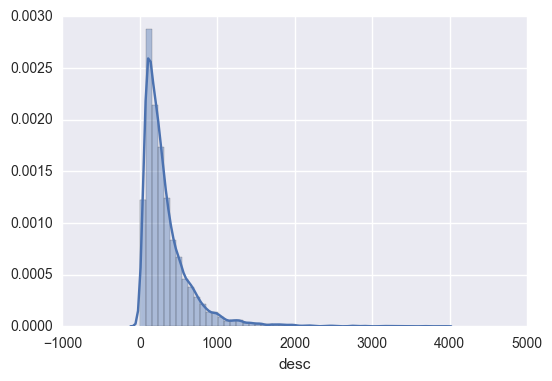

In [25]:
# How many null descriptions
print ("How many null descriptions? {}".format(len(df[df['desc'].isnull()])))

# Average length of non null descriptions
print ("Average length of Description Text {}".format(df['desc'].dropna().str.len().mean()))

sns.distplot(df['desc'].dropna().str.len())

In [102]:
# skip row 1 so pandas can parse the data properly.
loans_2005 = pd.read_csv('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/loan.csv', low_memory=False) 
half_count = len(loans_2005) / 2
loans_2005 = loans_2005.dropna(thresh=half_count, axis=1) # Drop any column with more than 50% missing values
#loans_2005 = loans_2005.drop(['url','desc'])      # These columns are not useful for our purposes

In [103]:
print ("Number of records {}".format(len(loans_2005)))
print ("Dataset Shape {}".format(loans_2005.shape))
loans_2005.head(5)
#loans_2005.columns

Number of records 887379
Dataset Shape (887379, 53)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,171.62,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,119.66,NaN,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,649.91,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,357.48,NaN,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,67.79,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [92]:
numeric_features = loans_2005.select_dtypes(include=[np.number])
numeric_features.describe()

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,...,887379.000000,887379.000000,887379.000000,887379.000000,887234.000000,887379.0,887350.000000,8.171030e+05,8.171030e+05,8.171030e+05
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,...,0.396692,45.919243,4.880757,2164.145585,0.014380,1.0,0.004991,2.257026e+02,1.394582e+05,3.206862e+04
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,...,4.087825,409.693874,63.125281,4794.783233,0.134191,0.0,0.077625,1.031137e+04,1.537500e+05,3.749826e+04
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,NaN,11.910000,NaN,...,0.000000,0.000000,0.000000,280.170000,NaN,1.0,NaN,NaN,NaN,NaN
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,NaN,17.650000,NaN,...,0.000000,0.000000,0.000000,462.780000,NaN,1.0,NaN,NaN,NaN,NaN
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,NaN,23.950000,NaN,...,0.000000,0.000000,0.000000,831.245000,NaN,1.0,NaN,NaN,NaN,NaN
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,...,358.680000,33520.270000,7002.190000,36475.590000,20.000000,1.0,14.000000,9.152545e+06,8.000078e+06,9.999999e+06


In [90]:
corr = numeric_features.corr()

print (corr['loan_amnt'].sort_values(ascending=False)[:5], '\n')
print (corr['loan_amnt'].sort_values(ascending=False)[-5:])

loan_amnt          1.000000
funded_amnt        0.999263
funded_amnt_inv    0.997115
installment        0.944977
out_prncp_inv      0.646898
Name: loan_amnt, dtype: float64 

tot_coll_amt                 -0.004275
collections_12_mths_ex_med   -0.016650
inq_last_6mths               -0.034168
pub_rec                      -0.081177
policy_code                        NaN
Name: loan_amnt, dtype: float64


In [91]:
categoricals = loans_2005.select_dtypes(exclude=[np.number])
categoricals.describe()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,887379,887379,887379,835922,887379,887379,887379,887379,887379,887379,...,887379,887228,887379,887379,887350,887379,869720,634408,887326,887379
unique,2,7,35,299272,12,6,3,103,10,2,...,14,63145,935,51,697,2,98,100,103,2
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Source Verified,Oct-2015,Current,n,...,debt_consolidation,Debt consolidation,945xx,CA,Aug-2001,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
freq,621125,254535,56323,13469,291569,443557,329558,48631,601779,887369,...,524215,414001,9770,129517,6659,456848,470150,553406,730574,886868


In [22]:
data_dictionary = pd.read_excel('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/LCDataDictionary.xlsx')

print(data_dictionary.shape[0])
print(data_dictionary.columns.tolist())

data_dictionary.rename(columns={'LoanStatNew': 'name',
                                'Description': 'description'})
data_dictionary.

80
['LoanStatNew', 'Description']


,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


In [ ]:
categorical_cols = ['grade', 'sub_grade', 'purpose', 'loan_status', 'home_ownership', 'emp_length', 'application_type']
id_cols = ['id', 'member_id']
time_cols = ['term', 'mths_since_last_record', 'issue_d', 'last_pymnt_d', 'next_pymnt_d']
status_cols = ['loan_status', 'verification_status', 'initial_list_status']
location_cols = ['zip_code', 'addr_state']
numerical_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', \
                  'total_pymnt', 'annual_inc', 'installment', 'open_acc', 'dti', 'emp_length' , 'out_prncp']
desc_cols = ['url', 'desc', 'title']

print(df[categorical_cols].head(30))
print(df[time_cols].head(30))
print(df[numerical_cols].head(30))
print(df[location_cols].head(30))
print(df[time_cols].head(30))
print(df[desc_cols].head(30))

In [108]:
# Code here
half_count = len(df) / 2
df_loans = df.dropna(thresh=half_count, axis=1) # Drop any column with more than 50% missing values
df_loans = df_loans.drop(['url','title'], axis=1)      # These columns are not useful for our purpose
#df_loans.info()

status_meaning = [
    "Loan is up to date on all outstanding payments.",
    "Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.",
    "Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached.",
    "Loan has not been current for 31 to 120 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.",
    "New loan that has passed all Lending Club reviews, received full funding, and has been issued.",
    "Loan is past due but within the 15-day grace period.",
    'Loan has not been current for 16 to 30 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.',
    "Does not meet the credit policy. Status:Fully ...",
    "Loan has not been current for 121 days or more. Learn more about the difference between “default” and “charge off”.",
    "Does not meet the credit policy. Status:Charge..."]

status, count = df_loans["loan_status"].value_counts().index, df_loans["loan_status"].value_counts().values

loan_statuses_explanation = pd.DataFrame({'Loan Status': status, 'Count': count, 'Meaning': status_meaning})[['Loan Status', 'Count', 'Meaning']]

pd.set_option('display.max_colwidth', 255)

loan_statuses_explanation

,Loan Status,Count,Meaning
0,Current,601779,Loan is up to date on all outstanding payments.
1,Fully Paid,207723,"Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment."
2,Charged Off,45248,"Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached."
3,Late (31-120 days),11591,Loan has not been current for 31 to 120 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.
4,Issued,8460,"New loan that has passed all Lending Club reviews, received full funding, and has been issued."
5,In Grace Period,6253,Loan is past due but within the 15-day grace period.
6,Late (16-30 days),2357,Loan has not been current for 16 to 30 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.
7,Does not meet the credit policy. Status:Fully Paid,1988,Does not meet the credit policy. Status:Fully ...
8,Default,1219,Loan has not been current for 121 days or more. Learn more about the difference between “default” and “charge off”.
9,Does not meet the credit policy. Status:Charged Off,761,Does not meet the credit policy. Status:Charge...


*Exploratory Visualization*

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_



In [104]:
df.term.value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

In [59]:
# Derive binary classifier
def is_default(row):
    if row['Fully Paid']:
        val = 0
    elif row['Current']:
        val = 0
    else:
        val = 1
    return val

df['isDefault'] = df['loan_status'].isin(['Current', 'Fully Paid'])

In [150]:
post_loan_features= ['open_acc_6m','open_il_6m','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util',\
    'open_rv_12m','open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi','total_cu_tl',\
    'inq_last_12m','acc_now_delinq','tot_coll_amt','tot_cur_bal']

df[post_loan_features].describe()
df.drop(post_loan_features, axis=1)

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint
0,5000.0,5000.0,4975.000000,36 months,10.65,162.87,NaN,10,RENT,24000.00,...,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
1,2500.0,2500.0,2500.000000,60 months,15.27,59.83,Ryder,1,RENT,30000.00,...,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
2,2400.0,2400.0,2400.000000,36 months,15.96,84.33,NaN,10,RENT,12252.00,...,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
3,10000.0,10000.0,10000.000000,36 months,13.49,339.31,AIR RESOURCES BOARD,10,RENT,49200.00,...,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
4,3000.0,3000.0,3000.000000,60 months,12.69,67.79,University Medical Group,1,RENT,80000.00,...,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
5,5000.0,5000.0,5000.000000,36 months,7.90,156.46,Veolia Transportaton,3,RENT,36000.00,...,161.03,NaN,Sep-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
6,7000.0,7000.0,7000.000000,60 months,15.96,170.08,Southern Star Photography,8,RENT,47004.00,...,170.08,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
7,3000.0,3000.0,3000.000000,36 months,18.64,109.43,MKC Accounting,9,RENT,48000.00,...,111.34,NaN,Dec-2014,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
8,5600.0,5600.0,5600.000000,60 months,21.28,152.39,NaN,4,OWN,40000.00,...,152.39,NaN,Aug-2012,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN
9,5375.0,5375.0,5350.000000,60 months,12.69,121.45,Starbucks,1,RENT,15000.00,...,121.45,NaN,Mar-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN


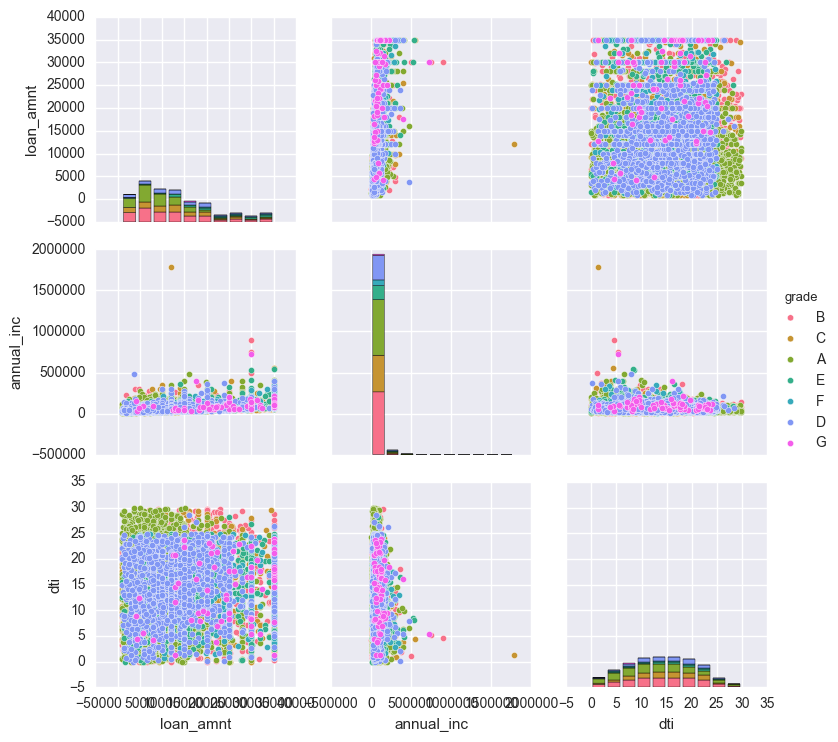

In [72]:
sns.pairplot(df[['loan_amnt', 'annual_inc', 'emp_length',  \
                  'dti', 'grade', 'loan_status']].dropna(), hue='grade')
g.set_xticklabels(rotation=30)

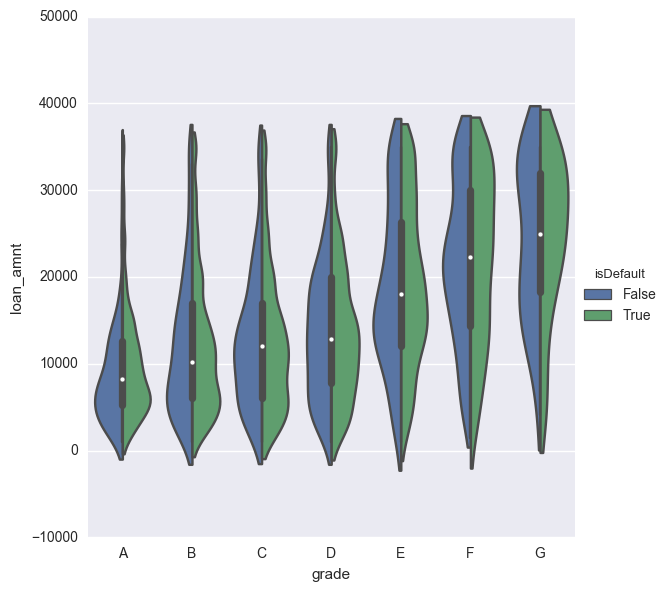

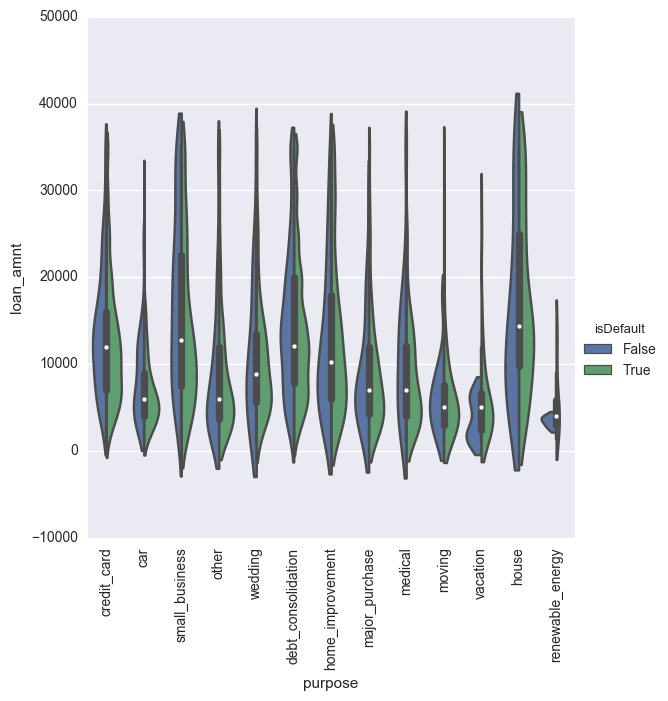

In [78]:
g = sns.factorplot(x="grade", y="loan_amnt", hue="isDefault", order=["A","B","C","D","E","F","G"], data=df, size=6, \
                    kind="violin", split=True, cut=1, aspect=1)

g2 = sns.factorplot(x="purpose", y="loan_amnt", hue="isDefault", data=df, size=6, \
                    kind="violin", split=True, cut=1, aspect=1)
g2.set_xticklabels(rotation=90)

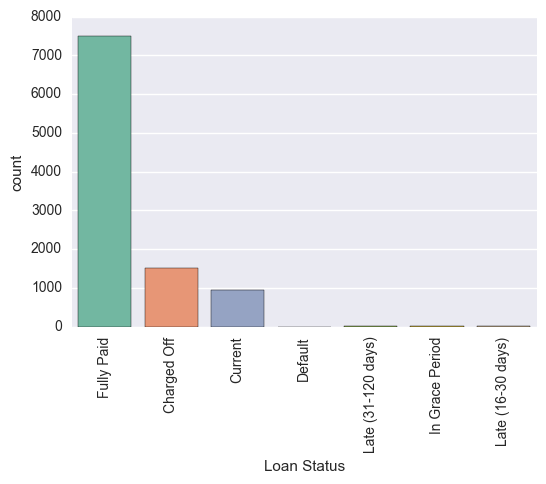

In [44]:
plt.xticks(rotation=90)

df_status = df.loc[df['loan_status'].isin(['Current','Charged Off','Default','Fully Paid','In Grace Period','Late (16-30 days)','Late (31-120 days)'])]

sns.countplot(df_status['loan_status'], palette='Set2')
plt.xlabel('Loan Status')

In [75]:
df.loc[df_loans['loan_status'] == 'Late (31-120 days)', 'loan_status'] = 'Late'
df.loc[df_loans['loan_status'] == 'Late (16-30 days)', 'loan_status'] = 'Late'

df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'], dtype=object)

In [76]:
df['loan_status'].value_counts()

Fully Paid            7487
Charged Off           1517
Current                956
Late (31-120 days)      24
In Grace Period          8
Late (16-30 days)        6
Default                  2
Name: loan_status, dtype: int64

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


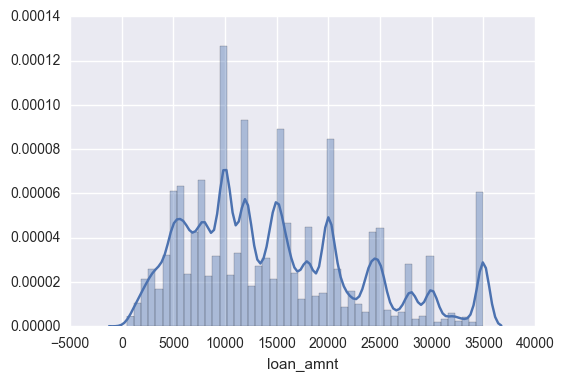

In [14]:
sns.distplot(df['loan_amnt'])

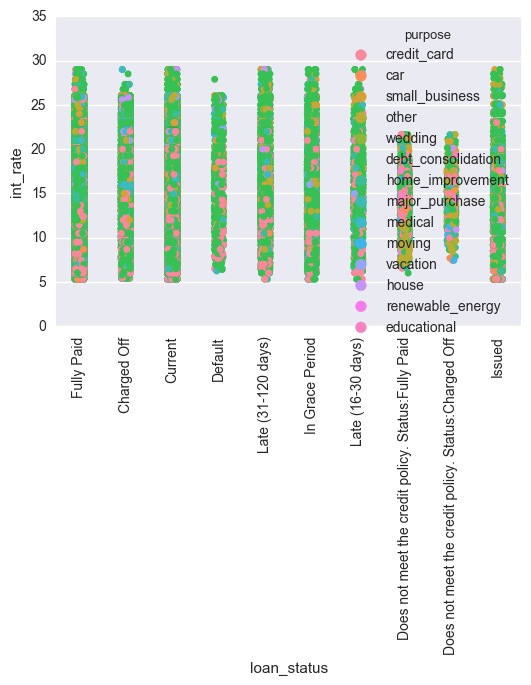

In [18]:
plt.xticks(rotation=90)
sns.stripplot(data=df[['loan_status','int_rate', 'purpose']], x='loan_status', y='int_rate', jitter=True, hue='purpose')

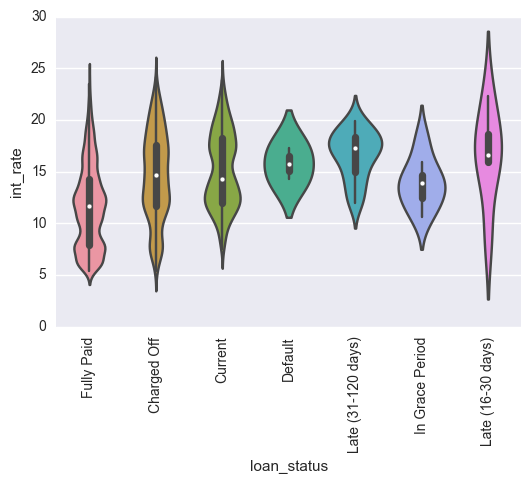

In [43]:
plt.xticks(rotation=90)
sns.violinplot(data=df[['loan_status', 'int_rate', 'grade']], x='loan_status', y='int_rate')

# Data Preprocessing

** Feature Cleaning abnomalies **

Converting data format and type for some features:

Employment Length

In [137]:
def print_data_shape(df):
    print ("No rows: {}".format(df.shape[0]))
    print ("No cols: {}".format(df.shape[1]))
    print (df.head(1).values)
    print ("Columns: " + df.columns)
    #df.info()

In [138]:
df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)
#df.emp_length.head()
print_data_shape(df)

No rows: 887379
No cols: 74
[[1077501 1296599 5000.0 5000.0 4975.0 ' 36 months' 10.65 162.87 'B' 'B2'
  nan 10 'RENT' 24000.0 'Verified' 'Dec-2011' 'Fully Paid' 'n'
  'https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501'
  '  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>'
  'credit_card' 'Computer' '860xx' 'AZ' 27.65 0.0 'Jan-1985' 1.0 nan nan
  3.0 0.0 13648.0 83.7 9.0 'f' 0.0 0.0 5861.07141425 5831.78 5000.0 861.07
  0.0 0.0 0.0 'Jan-2015' 171.62 nan 'Jan-2016' 0.0 nan 1.0 'INDIVIDUAL' nan
  nan nan 0.0 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]]
Index(['Columns: id', 'Columns: member_id', 'Columns: loan_amnt',
       'Columns: funded_amnt', 'Columns: funded_amnt_inv', 'Columns: term',
       'Columns: int_rate', 'Columns: installment', 'Columns: grade',
       'Columns: sub_grade', 'Columns: emp_title', 'Columns: emp_length',
       'Columns: home_ownership', 'Columns: annual_inc',
       'Columns: verificat

interest rate

In [122]:
#numeric_features.columns
categoricals.columns

#df.int_rate.head(10)
#df.int_rate = pd.Series(df.int_rate).str.replace('%', '').astype(float)

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type'],
      dtype='object')

Revolving Utility

In [119]:
df.revol_bal.head()
#df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

0    13648.0
1     1687.0
2     2956.0
3     5598.0
4    27783.0
Name: revol_bal, dtype: float64

Drop attributes populated post loan completion

In [141]:
df.drop(['out_prncp','out_prncp_inv','total_pymnt',
         'total_pymnt_inv','total_rec_prncp', 'grade', 'sub_grade'] ,1, inplace=True)

In [ ]:
# Drop surrogate identifiers
df.drop(['id','member_id'],1, inplace=True)

Look at correlation and eliminate highly correlated attributes

In [143]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

funded_amnt                  loan_amnt                 0.999263
funded_amnt_inv              loan_amnt                 0.997115
                             funded_amnt               0.998025
installment                  loan_amnt                 0.944977
                             funded_amnt               0.946005
                             funded_amnt_inv           0.943632
mths_since_last_delinq       delinq_2yrs              -0.562654
total_acc                    open_acc                  0.695075
collection_recovery_fee      recoveries                0.802420
mths_since_last_major_derog  mths_since_last_delinq    0.699356
annual_inc_joint             annual_inc                0.711091
open_il_24m                  open_il_12m               0.760552
total_bal_il                 open_il_6m                0.574424
open_rv_12m                  open_acc_6m               0.626833
open_rv_24m                  open_rv_12m               0.767262
max_bal_bc                   revol_bal  

Create Binary Classifier

In [144]:
df.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [148]:
mapping_dict = {'loan_status':{'Fully Paid':1,'Charged Off': 0,'Default': 0, 'Current': 1}}
df = df.replace(mapping_dict)
df = df[(df['loan_status'] == 1) | (df['loan_status'] == 0)]

print_data_shape(df)
df.loan_status.value_counts()

1    809502
0     46467
Name: loan_status, dtype: int64

Handle Missing values

In [153]:
def show_nulls(df):
    nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)[:25])
    nulls.columns = ['Null Count']   
    nulls.index.name = 'Feature'
    return nulls

show_nulls(df)

,Null Count
Feature,
dti_joint,855529
verification_status_joint,855527
annual_inc_joint,855527
il_util,844360
mths_since_rcnt_il,843035
total_cu_tl,842681
open_acc_6m,842681
open_il_6m,842681
open_il_12m,842681


*Algorithms and Techniques*

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_



*Benchmark*

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_


**III. Methodology**

*Data Preprocessing*

In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_


*Implementation*

In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_



*Refinement*

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_



** IV. Results **

*Model Evaluation and Validation*

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


*Justification*

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

**V. Conclusion**

Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_
